<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s5/EVA4S5F9_experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysis and result description

### Target: Reach 99.4% accuracy on validation using 10k params in 15 epochs
### 1. Process - Used Conv relu Conv block to forumalte the model
### 2. Results - Params - 9770
### 3. Best Train accuracy - 99.10
###    Best Test accuracy - 99.41
### 4. Analysis
###    a. The model has desired number of params
###   b. Using high dropout, can try to reduce that
###   c. Can use learning rate with lesser values




# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# The model
Let's start with the model we first saw

In [6]:
import torch.nn.functional as F
dropout_value = 0.08
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26, Receptive Field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 24, Receptive Field = 5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24, Receptive Field = 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, Receptive Field = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10, Receptive Field = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8, Receptive Field = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, Receptive Field = 18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, Receptive Field = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             100
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1,

# Training and Testing



In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:

from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

Loss=2.3001976013183594 Batch_id=0 Accuracy=14.06:   0%|          | 1/938 [00:00<02:13,  7.02it/s]

EPOCH: 0


Loss=0.22141149640083313 Batch_id=937 Accuracy=92.49: 100%|██████████| 938/938 [01:43<00:00,  9.06it/s]
Loss=0.16670465469360352 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:47,  8.69it/s]


Test set: Average loss: 0.0670, Accuracy: 9805/10000 (98.05%)

EPOCH: 1


Loss=0.0695563405752182 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [01:44<00:00,  9.00it/s]
Loss=0.15614457428455353 Batch_id=0 Accuracy=93.75:   0%|          | 1/938 [00:00<01:40,  9.33it/s]


Test set: Average loss: 0.0446, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.029849108308553696 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [01:43<00:00,  9.10it/s]
Loss=0.005614239722490311 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:46,  8.80it/s]


Test set: Average loss: 0.0347, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.09576278924942017 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [01:42<00:00,  9.14it/s]
Loss=0.02497772127389908 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:42,  9.18it/s]


Test set: Average loss: 0.0326, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.023544304072856903 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [01:42<00:00,  9.14it/s]
Loss=0.006637078709900379 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:47,  8.74it/s]


Test set: Average loss: 0.0261, Accuracy: 9924/10000 (99.24%)

EPOCH: 5


Loss=0.014437013305723667 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [01:42<00:00,  9.12it/s]
Loss=0.014578161761164665 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:41,  9.21it/s]


Test set: Average loss: 0.0284, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.0017658588476479053 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [01:42<00:00,  9.14it/s]
Loss=0.048259951174259186 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:45,  8.92it/s]


Test set: Average loss: 0.0261, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.015862425789237022 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [01:42<00:00,  9.14it/s]
Loss=0.08003430813550949 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:41,  9.26it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 8


Loss=0.018646197393536568 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [01:42<00:00,  9.19it/s]
Loss=0.008770499378442764 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:40,  9.29it/s]


Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.0021809865720570087 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [01:42<00:00,  9.15it/s]
Loss=0.03540223464369774 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:42,  9.12it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.07220494002103806 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [01:42<00:00,  9.13it/s]
Loss=0.08029782772064209 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:44,  8.98it/s]


Test set: Average loss: 0.0218, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.0066127413883805275 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [01:42<00:00,  9.18it/s]
Loss=0.039777159690856934 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:40,  9.28it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.055782727897167206 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [01:42<00:00,  9.17it/s]
Loss=0.04234716668725014 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:40,  9.31it/s]


Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.022484928369522095 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [01:42<00:00,  9.15it/s]
Loss=0.0023298657033592463 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:41,  9.25it/s]


Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.014951080083847046 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [01:42<00:00,  9.18it/s]



Test set: Average loss: 0.0185, Accuracy: 9937/10000 (99.37%)



Text(0.5, 1.0, 'Test Accuracy')

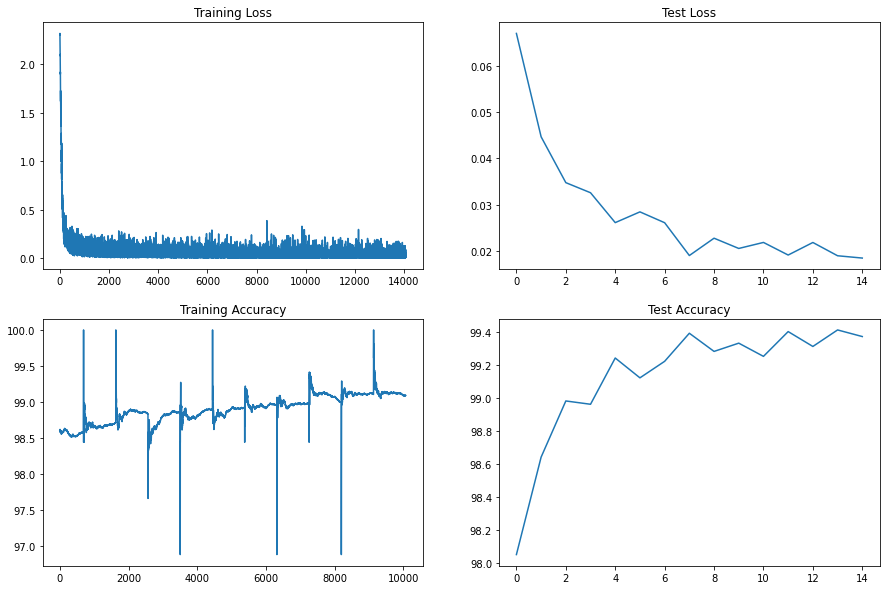

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")